Notebook para generar polinomio de regresión multivariable a un target dado.

# Librerias

In [1]:
#Machine Learning y ETL
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Funciones

In [2]:
def plot_distribution(df, column):
    plt.figure(figsize=(16, 5))

    plt.subplot(1, 3, 1)
    sns.histplot(df[column], kde=True)
    plt.title(f'Histograma de {column}')

    plt.subplot(1, 3, 2)
    stats.probplot(df[column].dropna(), dist="norm", plot=plt)
    plt.title(f'Gráfico Q-Q de {column}')

    plt.subplot(1, 3, 3)
    sns.boxplot(x=df[column], orient="y")
    plt.title(f'Boxplot de {column}')
    
    plt.show()

# Carga de datos

Ingrese el path de su csv

In [3]:
df = pd.read_csv(r"Data\MC-WTG13.csv", header=0, index_col=0)

Info DataSet

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8987 entries, 2023-01-01T03:00:00Z to 2023-04-27T04:40:00Z
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Ambient.WindDir      8987 non-null   float64
 1   Ambient.WindSpeed    8987 non-null   float64
 2   Grid.Power           8987 non-null   float64
 3   Ambient.Temperature  8983 non-null   float64
dtypes: float64(4)
memory usage: 351.1+ KB


Descripción de Estadísticos Basicos del DataSet

In [5]:
df.describe()

,Ambient.WindDir,Ambient.WindSpeed,Grid.Power,Ambient.Temperature
count,8987.000000,8987.000000,8987.000000,8983.000000
mean,184.477017,8.102771,1635.301172,21.193254
std,121.231617,2.881985,1164.356527,6.332740
min,0.350000,2.490000,100.200000,6.000000
25%,74.065000,5.820000,564.680000,17.000000
50%,177.410000,7.660000,1361.600000,20.000000
75%,316.790000,9.890000,2738.995000,25.000000
max,359.830000,23.490000,3652.990000,39.000000


Chequeo de Nulos

In [6]:
df.isnull().sum()/df.shape[0]*100

Ambient.WindDir        0.000000
Ambient.WindSpeed      0.000000
Grid.Power             0.000000
Ambient.Temperature    0.044509
dtype: float64

Distribución de Variables

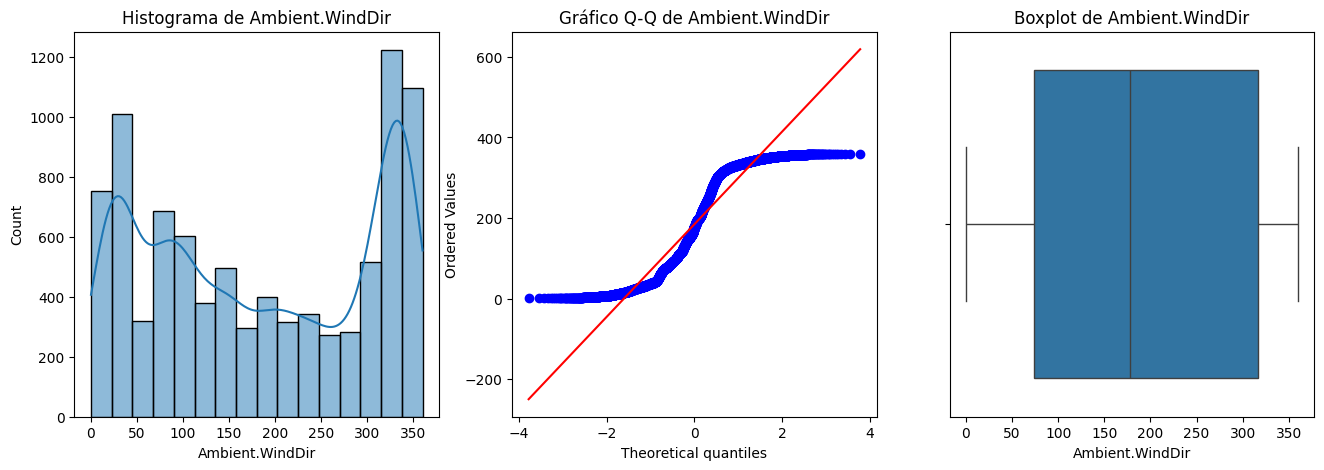

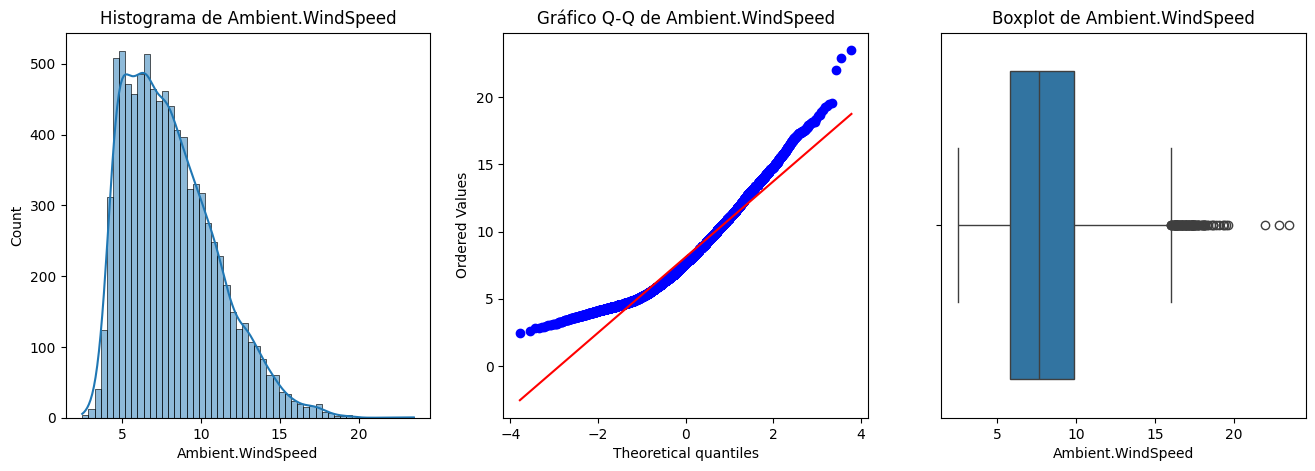

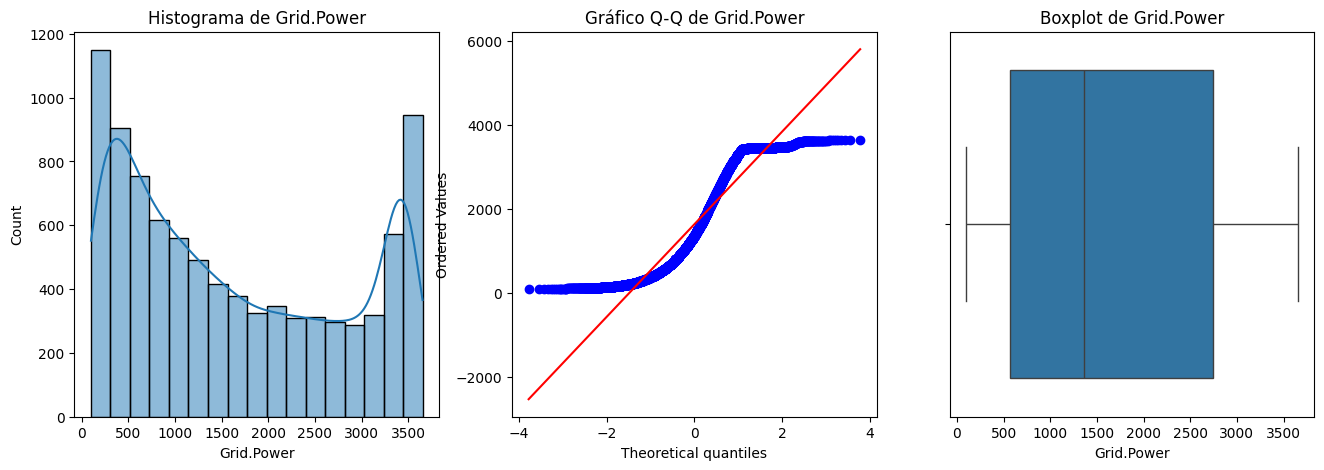

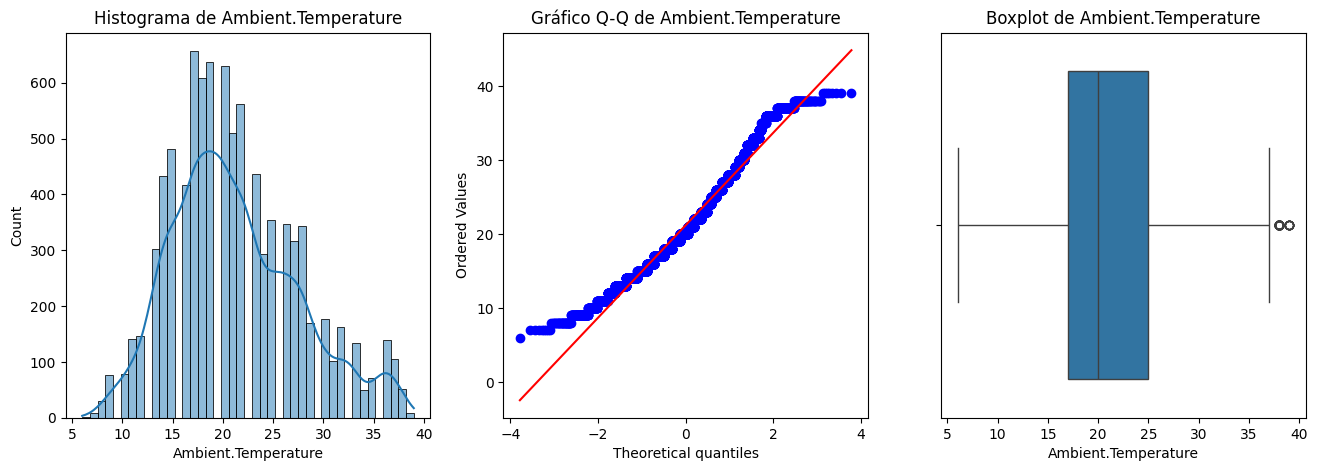

In [7]:
for column in df.select_dtypes(include=[np.number]).columns:
    plot_distribution(df, column)

Tratamiento de datos

In [8]:
df.fillna(method='ffill', inplace=True)

C:\Users\jadurian\AppData\Local\Temp\ipykernel_14268\3970806690.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Chequeo

In [9]:
print(df.isnull().sum())

Ambient.WindDir        0
Ambient.WindSpeed      0
Grid.Power             0
Ambient.Temperature    0
dtype: int64


## Especificacion del target y variables independientes

Importante definir del DataSet, cual variable es el target y cuales son los términos independientes.

In [10]:
print(f"Tus columnas son:\n")
for i in df.columns:
    print(i)

Tus columnas son:

Ambient.WindDir
Ambient.WindSpeed
Grid.Power
Ambient.Temperature


In [11]:
target = input("Ingrese el texto completo de su variable elegida como target: ")

In [12]:
X = df.drop(target, axis=1) # X es un dataframe que contiene únicamente a las variables independientes o inputs del modelo
y = df[[target]] # y es la variable objetivo a regresionar o target

Matriz de correlación de variables

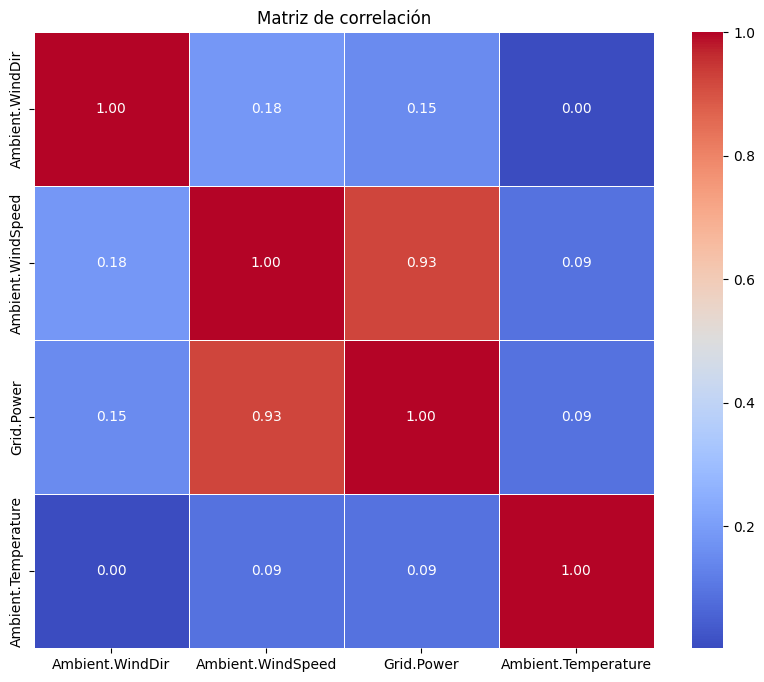

In [13]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de correlación')
plt.show()

Testeo de resultados para distintos grados de polinomio

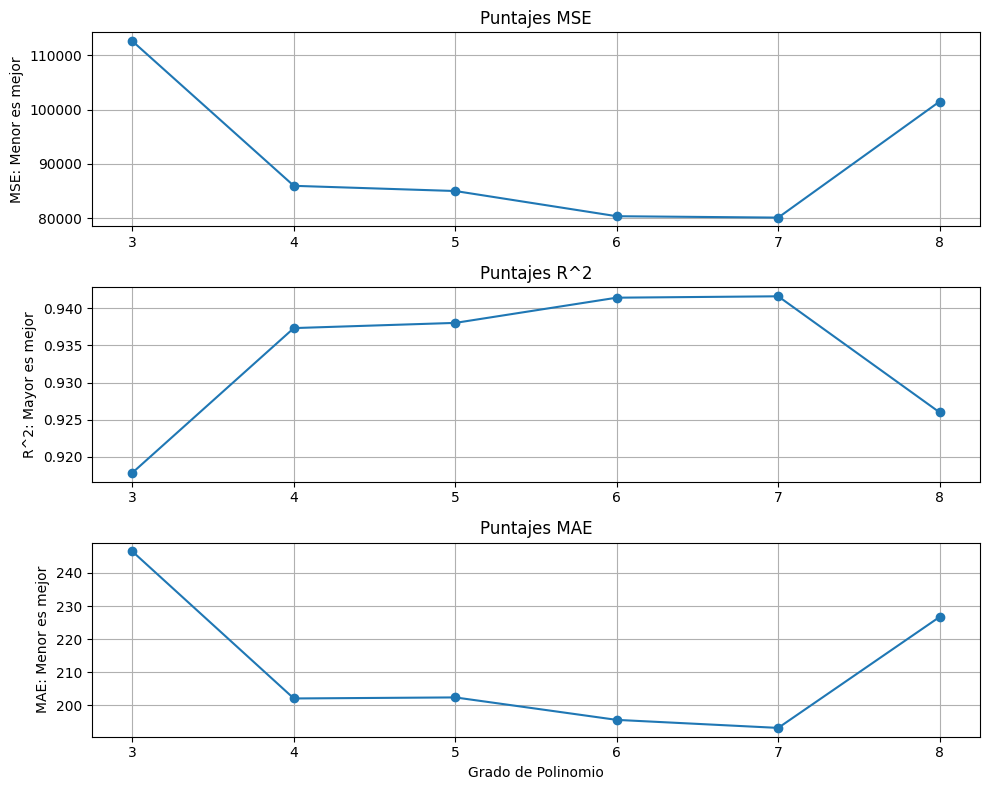

In [14]:
grados_pol = [3,4,5,6,7,8]
plt_mean_squared_error = []
lista_puntajes = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mse_scores = []
r2_scores = []
mae_scores = []

for degree in grados_pol:
    # Crear el pipeline con PolynomialFeatures y LinearRegression
    model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression())
    
    # Entrenar el modelo utilizando los datos de entrenamiento
    model.fit(X_train, y_train)
    
    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)
    
    # Calcular los puntajes
    mse_scores.append(mean_squared_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))
    mae_scores.append(mean_absolute_error(y_test, y_pred))

# Crear gráficos separados para cada métrica
plt.figure(figsize=(10, 8))

# Gráfico para MSE
plt.subplot(3, 1, 1)
plt.plot(grados_pol, mse_scores, marker='o')
plt.ylabel('MSE: Menor es mejor')
plt.title('Puntajes MSE')
plt.grid(True)

# Gráfico ara R2
plt.subplot(3, 1, 2)
plt.plot(grados_pol, r2_scores, marker='o')
plt.ylabel('R^2: Mayor es mejor')
plt.title('Puntajes R^2')
plt.grid(True)

# Gráfico para MAE
plt.subplot(3, 1, 3)
plt.plot(grados_pol, mae_scores, marker='o')
plt.ylabel('MAE: Menor es mejor')
plt.xlabel('Grado de Polinomio')
plt.title('Puntajes MAE')
plt.grid(True)

plt.tight_layout()
plt.show()

Elegido el grado con mejores resultados, seteamos el polinomio en el argumento "degree=X"

In [15]:
#Seteo el polinomio para grado seleccionado
model = make_pipeline(PolynomialFeatures(degree=4, interaction_only=False), LinearRegression())

# Entrenar el modelo utilizando los datos de entrenamiento
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

Resultados

In [16]:
# Calcular los puntajes
print("MSE: ",mean_squared_error(y_test, y_pred))
print("R2: ",r2_score(y_test, y_pred))
print("MAE: ",mean_absolute_error(y_test, y_pred))

MSE:  85947.05057054732
R2:  0.9373170737488259
MAE:  202.05400136136993


Estadíticos:

- **Error absoluto medio (MAE)**: Representa el promedio de la diferencia absoluta entre los valores reales y los valores predichos en el conjunto de datos. Es una medida de la precisión del modelo y se expresa en la misma escala que la variable dependiente. La fórmula es:

  $$ MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i| $$

- **Error cuadrático medio (MSE)**: Representa el promedio de las diferencias al cuadrado entre los valores reales y los valores predichos. Mide la varianza de los residuos. La fórmula es:

  $$ MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $$

- **Raíz del error cuadrático medio (RMSE)**: Es simplemente la raíz cuadrada del MSE. Se utiliza para medir la desviación estándar de los residuos. La fórmula es:

  $$ RMSE = \sqrt{MSE} $$

- **Coeficiente de determinación (R2)**: Representa la proporción de la varianza en la variable dependiente que se explica mediante el modelo de regresión lineal. Su valor siempre está entre 0 y 1. La fórmula es:

  $$ R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2} $$

- **R2 ajustado**: Es una versión modificada de R2 que tiene en cuenta el número de variables independientes en el modelo. Siempre es menor o igual a R2. La fórmula es:

  $$ R^2_{\text{ajustado}} = 1 - \frac{(1 - R^2) \cdot (n - 1)}{n - k - 1} $$

  Donde:
  - \(n\) es el número de observaciones en los datos.
  - \(k\) es el número de variables independientes en el modelo.

En resumen, un valor más bajo de MAE, MSE y RMSE indica mayor precisión del modelo, mientras que un valor más alto de R2 es deseable para explicar la variabilidad en la variable dependiente¹²³. Espero que esta explicación te sea útil.

In [17]:
y_test.shape

(1798, 1)

In [18]:
y_pred.shape

(1798, 1)

## Cross Validation

Método de Validación Cruzada para asegurarnos que la generalidad del modelo en distintos folds del DataSet es buena

In [19]:
# Realizar la validación cruzada con 5 folds
scores = cross_val_score(model, X, y, cv=5, scoring='r2')

# Imprimir los puntajes de R^2 para cada fold
print("Puntajes de R^2 para cada fold:", scores)

# Imprimir el promedio de los puntajes de R^2
print("Promedio de R^2:", np.mean(scores))

if np.mean(scores) > 0.7:
    print("La validación cruzada demostró que el modelo generaliza bien")
else: 
    print("El resultado demostró que no es un modelo óptimo")

Puntajes de R^2 para cada fold: [0.93004976 0.93995341 0.94720315 0.93070246 0.90460755]
Promedio de R^2: 0.9305032655226764
La validación cruzada demostró que el modelo generaliza bien


Plot resultados Validación Cruzada

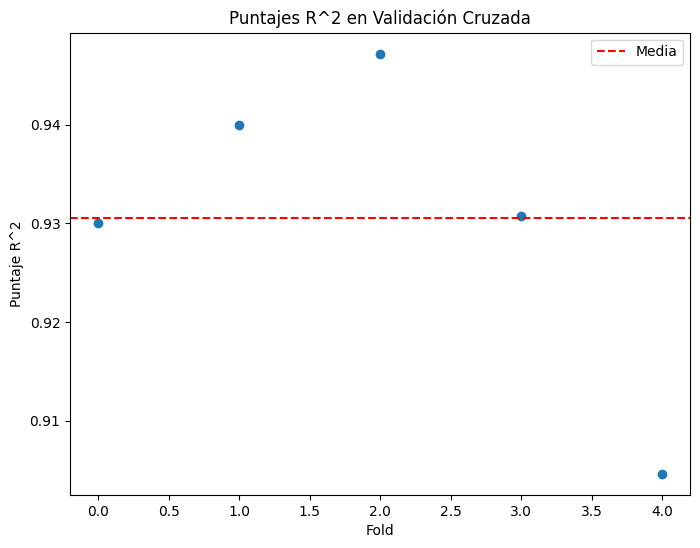

In [20]:
plt.figure(figsize=(8, 6))
plt.scatter(range(len(scores)), scores)
plt.axhline(scores.mean(), color='red', linestyle='dashed', label='Media')
plt.xlabel('Fold')
plt.ylabel('Puntaje R^2')
plt.title('Puntajes R^2 en Validación Cruzada')
plt.legend()
plt.show()

Desarrollo para llegar al polinomio

In [21]:
poly_model = model[0]
lineal_model = model[1]

features_names_in = poly_model.feature_names_in_
n_output_features_ = poly_model.n_output_features_



print(n_output_features_)
print(features_names_in[:])

#print(len(model[0].get_feature_names_out(model[0].feature_names_in_[:])))

#print(model[0].get_feature_names_out(["Ambient.WindSpeed","Ambient.Temperature","Ambient.WindDir"])

35
['Ambient.WindDir' 'Ambient.WindSpeed' 'Ambient.Temperature']


In [22]:
# Obtener el término independiente (intercept) del modelo ajustado
intercept = model[1].intercept_
intercept = str(intercept)
# Obtener los coeficientes de todas las características polinómicas generadas por PolynomialFeatures
coeficientes = model[1].coef_[0]

# Obtener los nombres de todas las características generadas por PolynomialFeatures
nombres_caracteristicas = poly_model.get_feature_names_out()

In [23]:
print(type(model[1].intercept_))
print(coeficientes)
print(nombres_caracteristicas)


<class 'numpy.ndarray'>
[ 1.08997669e-04 -8.08333233e+00 -2.33754116e+03  1.92016614e+02
 -8.04978881e-03  3.00717554e+00  1.06027099e-01  4.35931393e+02
 -3.93103437e+01 -7.73824216e+00  1.08230748e-04 -1.48990927e-03
 -1.41131757e-03 -1.95957932e-01 -7.43607139e-02  1.53747226e-02
 -2.67287535e+01  2.11470070e+00  1.42624974e+00  6.01813787e-02
 -1.14126607e-07 -5.68595825e-06  8.98700420e-07  6.97741749e-05
  1.31738953e-04  4.59493345e-06  3.57420386e-03  2.76999592e-03
 -3.39550971e-04 -2.01053189e-04  5.31428663e-01 -3.77390775e-02
 -3.75654849e-02 -1.32486713e-02  5.51362835e-04]
['1' 'Ambient.WindDir' 'Ambient.WindSpeed' 'Ambient.Temperature'
 'Ambient.WindDir^2' 'Ambient.WindDir Ambient.WindSpeed'
 'Ambient.WindDir Ambient.Temperature' 'Ambient.WindSpeed^2'
 'Ambient.WindSpeed Ambient.Temperature' 'Ambient.Temperature^2'
 'Ambient.WindDir^3' 'Ambient.WindDir^2 Ambient.WindSpeed'
 'Ambient.WindDir^2 Ambient.Temperature'
 'Ambient.WindDir Ambient.WindSpeed^2'
 'Ambient.WindDir A

In [24]:
lista_sin_espacios = [elemento.replace(" ", "*") for elemento in nombres_caracteristicas]

In [25]:
lista_sin_espacios[:]

['1',
 'Ambient.WindDir',
 'Ambient.WindSpeed',
 'Ambient.Temperature',
 'Ambient.WindDir^2',
 'Ambient.WindDir*Ambient.WindSpeed',
 'Ambient.WindDir*Ambient.Temperature',
 'Ambient.WindSpeed^2',
 'Ambient.WindSpeed*Ambient.Temperature',
 'Ambient.Temperature^2',
 'Ambient.WindDir^3',
 'Ambient.WindDir^2*Ambient.WindSpeed',
 'Ambient.WindDir^2*Ambient.Temperature',
 'Ambient.WindDir*Ambient.WindSpeed^2',
 'Ambient.WindDir*Ambient.WindSpeed*Ambient.Temperature',
 'Ambient.WindDir*Ambient.Temperature^2',
 'Ambient.WindSpeed^3',
 'Ambient.WindSpeed^2*Ambient.Temperature',
 'Ambient.WindSpeed*Ambient.Temperature^2',
 'Ambient.Temperature^3',
 'Ambient.WindDir^4',
 'Ambient.WindDir^3*Ambient.WindSpeed',
 'Ambient.WindDir^3*Ambient.Temperature',
 'Ambient.WindDir^2*Ambient.WindSpeed^2',
 'Ambient.WindDir^2*Ambient.WindSpeed*Ambient.Temperature',
 'Ambient.WindDir^2*Ambient.Temperature^2',
 'Ambient.WindDir*Ambient.WindSpeed^3',
 'Ambient.WindDir*Ambient.WindSpeed^2*Ambient.Temperature',
 'Am

In [26]:
lista2 = list()

for i in range(len(lista_sin_espacios)):
    b = str()
    elemento = lista_sin_espacios[i]
    
    if "*" in elemento and "^" in elemento:

        elemento = elemento.replace("*", "*'")

        elemento = elemento.replace("^", "'^")
        b = elemento
    
    elif "^" in elemento and not("*" in elemento):
        elemento = elemento.replace("^", "'^")
        b = elemento

    elif "*" in elemento and not("^" in elemento):
        elemento = elemento.replace("*", "'*'")

        b = elemento

    else:
        b = elemento
    
    lista2.append(b)

lista2


['1',
 'Ambient.WindDir',
 'Ambient.WindSpeed',
 'Ambient.Temperature',
 "Ambient.WindDir'^2",
 "Ambient.WindDir'*'Ambient.WindSpeed",
 "Ambient.WindDir'*'Ambient.Temperature",
 "Ambient.WindSpeed'^2",
 "Ambient.WindSpeed'*'Ambient.Temperature",
 "Ambient.Temperature'^2",
 "Ambient.WindDir'^3",
 "Ambient.WindDir'^2*'Ambient.WindSpeed",
 "Ambient.WindDir'^2*'Ambient.Temperature",
 "Ambient.WindDir*'Ambient.WindSpeed'^2",
 "Ambient.WindDir'*'Ambient.WindSpeed'*'Ambient.Temperature",
 "Ambient.WindDir*'Ambient.Temperature'^2",
 "Ambient.WindSpeed'^3",
 "Ambient.WindSpeed'^2*'Ambient.Temperature",
 "Ambient.WindSpeed*'Ambient.Temperature'^2",
 "Ambient.Temperature'^3",
 "Ambient.WindDir'^4",
 "Ambient.WindDir'^3*'Ambient.WindSpeed",
 "Ambient.WindDir'^3*'Ambient.Temperature",
 "Ambient.WindDir'^2*'Ambient.WindSpeed'^2",
 "Ambient.WindDir'^2*'Ambient.WindSpeed*'Ambient.Temperature",
 "Ambient.WindDir'^2*'Ambient.Temperature'^2",
 "Ambient.WindDir*'Ambient.WindSpeed'^3",
 "Ambient.WindDir*'A

In [27]:
def agregar_comilla_astrisco(lista_strings):
    nueva_lista = []

    for elemento in lista_strings:
        pos_ast = elemento.find('*')

        if pos_ast > 0 and elemento[pos_ast - 1].isalpha():
            nuevo_elemento = elemento[:pos_ast] + "'" + elemento[pos_ast:]
            nueva_lista.append(nuevo_elemento)
        else:
            nueva_lista.append(elemento)

    return nueva_lista

lista_con_comilla = agregar_comilla_astrisco(lista2)
lista_con_comilla

['1',
 'Ambient.WindDir',
 'Ambient.WindSpeed',
 'Ambient.Temperature',
 "Ambient.WindDir'^2",
 "Ambient.WindDir'*'Ambient.WindSpeed",
 "Ambient.WindDir'*'Ambient.Temperature",
 "Ambient.WindSpeed'^2",
 "Ambient.WindSpeed'*'Ambient.Temperature",
 "Ambient.Temperature'^2",
 "Ambient.WindDir'^3",
 "Ambient.WindDir'^2*'Ambient.WindSpeed",
 "Ambient.WindDir'^2*'Ambient.Temperature",
 "Ambient.WindDir'*'Ambient.WindSpeed'^2",
 "Ambient.WindDir'*'Ambient.WindSpeed'*'Ambient.Temperature",
 "Ambient.WindDir'*'Ambient.Temperature'^2",
 "Ambient.WindSpeed'^3",
 "Ambient.WindSpeed'^2*'Ambient.Temperature",
 "Ambient.WindSpeed'*'Ambient.Temperature'^2",
 "Ambient.Temperature'^3",
 "Ambient.WindDir'^4",
 "Ambient.WindDir'^3*'Ambient.WindSpeed",
 "Ambient.WindDir'^3*'Ambient.Temperature",
 "Ambient.WindDir'^2*'Ambient.WindSpeed'^2",
 "Ambient.WindDir'^2*'Ambient.WindSpeed*'Ambient.Temperature",
 "Ambient.WindDir'^2*'Ambient.Temperature'^2",
 "Ambient.WindDir'*'Ambient.WindSpeed'^3",
 "Ambient.WindDi

In [28]:
print(coeficientes.shape)

print(nombres_caracteristicas.shape)

(35,)
(35,)


In [29]:
poli = f"{intercept[1:-1]}+"

for i, coef in enumerate(coeficientes):
    
    #print(lista2[i])
    #print(coef)
    

    if lista_con_comilla[i][0].isalpha() and lista_con_comilla[i][-1].isdigit():

            poli += f"{coef:.20f}*'{lista_con_comilla[i]}+"
            #print(f"'{lista2[i]}+{coef}")

    else :
        poli += f"{coef:.20f}*'{lista_con_comilla[i]}'+"

        #print(f"{coef:f}")
        #print(coef)


Renombrar las variables PiPoints con los nombres de los atributos o variables en PI

In [30]:
poli = poli.replace("+-","-")
poli = poli.replace("'Ambient.WindSpeed'","'Velocidad de Viento'")
poli = poli.replace("'Ambient.WindDir'","'Dirección de viento'")
poli = poli.replace("'Ambient.WindDir","'Dirección de viento'")
poli = poli.replace("'Ambient.Temperature'","'Temperatura Ambiente'")

Polinomio

In [31]:
poli

"3762.20507776+0.00010899766930765657*'1'-8.08333233484412083669*'Dirección de viento'-2337.54116079117102344753*'Velocidad de Viento'+192.01661443608946910899*'Temperatura Ambiente'-0.00804978881064102002*'Dirección de viento'^2+3.00717554462041203323*'Dirección de viento'*'Velocidad de Viento'+0.10602709926188624845*'Dirección de viento'*'Temperatura Ambiente'+435.93139290988068523802*'Velocidad de Viento'^2-39.31034365208750358534*'Velocidad de Viento'*'Temperatura Ambiente'-7.73824216249200169671*'Temperatura Ambiente'^2+0.00010823074796060580*'Dirección de viento'^3-0.00148990927282910933*'Dirección de viento'^2*'Velocidad de Viento'-0.00141131756760753957*'Dirección de viento'^2*'Temperatura Ambiente'-0.19595793222664581457*'Dirección de viento'*'Velocidad de Viento'^2-0.07436071394804594226*'Dirección de viento'*'Velocidad de Viento'*'Temperatura Ambiente'+0.01537472262910999886*'Dirección de viento'*'Temperatura Ambiente'^2-26.72875350288328633042*'Velocidad de Viento'^3+2.1147